# STREAM CCD bandwidth, different thread locations, for all userspace frequencies, on AMD EPYC 7702

## Load necessary depencencies

In [1]:
import numpy
import csv
import re
import os
import matplotlib.pyplot as plt
import matplotlib

## Define functions

In [2]:
# taken from https://github.com/kloopuk/log-progress

# MIT License
#
# Copyright (c) 2016 bureaucratic-labs
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [3]:
# generate lists of files with files according to search parameters
def listgenerator (filelist, case, cores, frequency, retlist):
    
    for file in filelist:
        string = "intel-" + case + "-c_" + str(cores) + "-" + str(frequency) + "MHz"
      
        if string in file:
            retlist.append(file) 
            break

In [4]:
# calculate averages and standard deviations from values in file list 
def evaluation(filelist, case, threads, frequency, function):
    values = numpy.array([])
    averages = numpy.array([])
    stdevs = numpy.array([])

    core_found = False
    data_found = False


    # iterate over lines in file
    for file in filelist:

        string = "intel-" + case + "-c_" + str(threads) + "-" + str(frequency) + "MHz"
        if string in file:
 
            for line in open(file):
                # check if file has data for function
                if line.startswith(function):
                    core_found = True

                    values = numpy.append(values, float(line.split()[1])/1000)


    averages = numpy.average(values)
    stdevs = numpy.std(values)

    return averages, stdevs

In [5]:
# plotter function
def plotter(averages, threads, frequencies, function, machine):

    fig, ax = plt.subplots()
    im = ax.imshow(averages, cmap='jet')
    
    cases = ["1 CCD,\n1CCX", "1 CCD,\n2 CCX", "2 CCD,\n1CCX per CCD", "2 CCD,\n2 CCX per CCD"]
    
    # set title
    ax.set_title('STREAM ' + function + ' RAM Bandwidth in [GB/s], on ' + machine + '\n')
    
    # setup for main axes
    xlabels = numpy.array(threads)
    ylabels = numpy.array(frequencies)
   
    x = numpy.arange(len(xlabels))
    y = numpy.arange(len(ylabels))
    
    ax.set_xlabel('Number of used Cores')
    ax.set_ylabel('Frequency in [MHz]')

    ax.set_xticks(x)
    ax.set_yticks(y)
    ax.set_xticklabels(xlabels, rotation=0, ha='center', rotation_mode='anchor') 
    ax.set_yticklabels(ylabels, rotation=0, ha='right', rotation_mode='anchor') 
    
    # create colorbar
    cbarlabel = 'Bandwidth in [GB/s]'
    
    cbarticks = numpy.arange(round(averages.min())+1, round(averages.max()), 3)
    cbar = ax.figure.colorbar(im, shrink=0.3, pad=0.02, ticks=cbarticks)
    cbar.ax.set_ylabel(cbarlabel, rotation=+90, va="top")
 
    # secondary y-axis
    def cyctons(x):
        return (x-1.5) * len(cases)
    
    def nstocyc(x):
        return (x-1.5)/len(cases)

    secax = ax.secondary_xaxis('top', functions =(nstocyc, cyctons)) 
    secax.set_xticks(numpy.arange(len(cases), step=1))
    secax.set_xticklabels(cases)
    secax.set_xlabel('Threads spread across 1 Node, ...')
    
    # set color for font depending on value
    thresholdLower = im.norm(averages.max())/3.
    thresholdUpper = im.norm(averages.max())/1.2
   
    textcolors=("white", "black")
    
    lc = 'white'
    lw = 3
    ax.axvline(x=3.5, color=lc, linewidth=lw)
    ax.axvline(x=7.5, color=lc, linewidth=lw)
    ax.axvline(x=11.5, color=lc, linewidth=lw)
   
    # Loop over data dimensions and create text annotations.
    for j in range(len(xlabels)):
        for i in range(len(ylabels)):
            if averages[i, j] > 100:
                value = round(averages[i, j])
            else:
                value = round(averages[i, j], 1)

            text = ax.text(j, i, value,
                           ha="center", va="center", 
                           size="x-small",
                           color=textcolors[int(im.norm(averages[i, j]) > 
                                                thresholdLower and im.norm(averages[i, j]) < 
                                                thresholdUpper)]) 
    
    # ensure proper layout
    fig.tight_layout()
        
    # save plot to file
    filename = '../../../paper/fig/' + machine + '-STREAM-' + function  + '.png'
    
    matplotlib.pyplot.savefig(filename, dpi=300, format='png') 
    print(filename + ' has been saved to disk.')


## Create file lists

In [6]:
# get list of all files in directory
path = 'datafiles'

filelist = []

for entry in log_progress(os.scandir(path), True): 
    filelist.append(entry.path)

print("Number of files found: " + str(len(filelist)))

Number of files found: 48


## Process data

In [7]:
functions = ['Copy', 'Scale', 'Add', 'Triad']

cases = ["1CCD_1CCX", "1CCD_2CCX", "2CCD_2CCX", "2CCD_4CCX"]

frequencies = [2000, 1800, 1500]

threadlist = [1,2,3,4,2,4,6,8,2,4,6,8,4,8,12,16]

averages = numpy.zeros([len(functions), len(frequencies), len(threadlist)])
stdevs = numpy.zeros([len(functions), len(frequencies), len(threadlist)])

for function in log_progress(functions):
    function_index = functions.index(function)
    
    for case in cases:
        case_index = cases.index(case)

        for i in range(4):
            threads = threadlist[len(cases) * case_index + i]
            threads_index = len(cases) * case_index + i

            for frequency in frequencies:
                frequency_index = frequencies.index(frequency)
        
                averages[function_index][frequency_index][threads_index], \
                stdevs[function_index][frequency_index][threads_index] = \
                evaluation(filelist, case, threads, frequency, function)
        

## Plot Data

../../../paper/fig/AMD EPYC 7702-STREAM-Copy.png has been saved to disk.
../../../paper/fig/AMD EPYC 7702-STREAM-Scale.png has been saved to disk.
../../../paper/fig/AMD EPYC 7702-STREAM-Add.png has been saved to disk.
../../../paper/fig/AMD EPYC 7702-STREAM-Triad.png has been saved to disk.


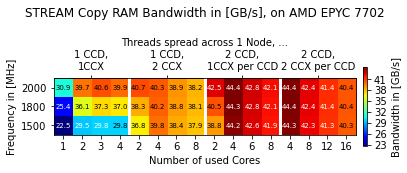

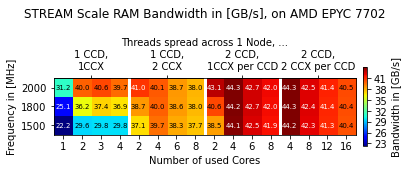

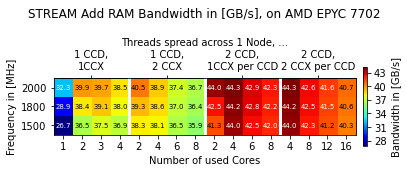

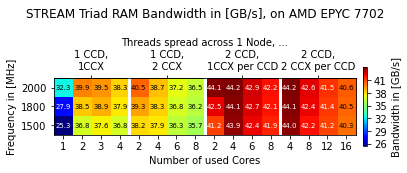

In [8]:
for function in log_progress(functions):
    function_index = functions.index(function)
        
    plotter(averages[function_index], threadlist, frequencies, function, 'AMD EPYC 7702')